# Bank marketing deposit 
## Prediction task for DZ bank

In [ ]:
# Import packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from ucimlrepo import fetch_ucirepo

In [ ]:
# Get Data
bank_marketing = fetch_ucirepo(id=222) 
  
X = bank_marketing.data.features 
y = bank_marketing.data.targets 

df = pd.concat([y, X], axis = 1)

In [22]:
# Look at df
df

,y,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
0,no,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN
1,no,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN
2,no,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN
3,no,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN
4,no,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,yes,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,NaN
45207,yes,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,NaN
45208,yes,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success
45209,no,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,NaN


In [23]:
# Length
len(df)

45211

In [24]:
# Columns
df.columns

Index(['y', 'age', 'job', 'marital', 'education', 'default', 'balance',
       'housing', 'loan', 'contact', 'day_of_week', 'month', 'duration',
       'campaign', 'pdays', 'previous', 'poutcome'],
      dtype='object')

# Data exploration

In [25]:
# Check missing values
pd.DataFrame({'n_missing': df.isnull().sum(), 'share_missing': round(df.isnull().sum()/len(df),2)})

,n_missing,share_missing
y,0,0.00
age,0,0.00
job,288,0.01
marital,0,0.00
education,1857,0.04
default,0,0.00
balance,0,0.00
housing,0,0.00
loan,0,0.00
contact,13020,0.29


`poutcome` and `contact` have a lot of missing values. For `job` and `education` it's less severe. The latter two should have no NA's according to the description, which is strange.

In [26]:
## Group columns by type for plotting
# Categorial
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','poutcome']
# Numeric
num_cols = ['balance', 'day_of_week','duration', 'age','campaign', 'pdays', 'previous']


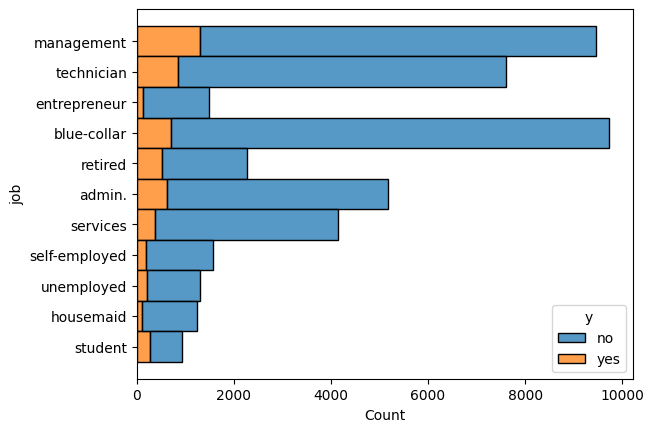

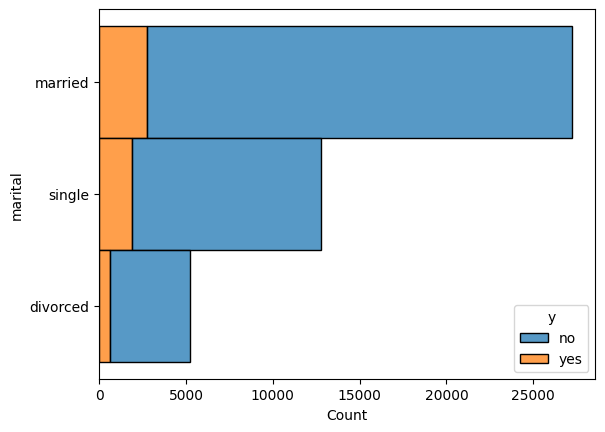

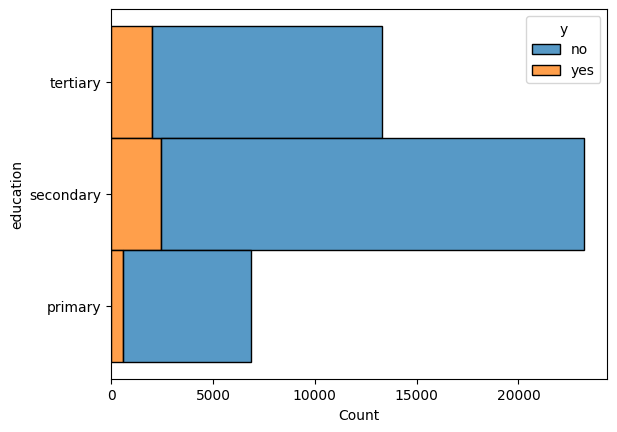

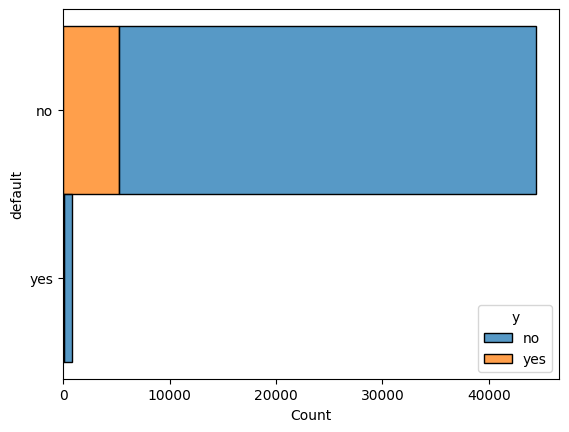

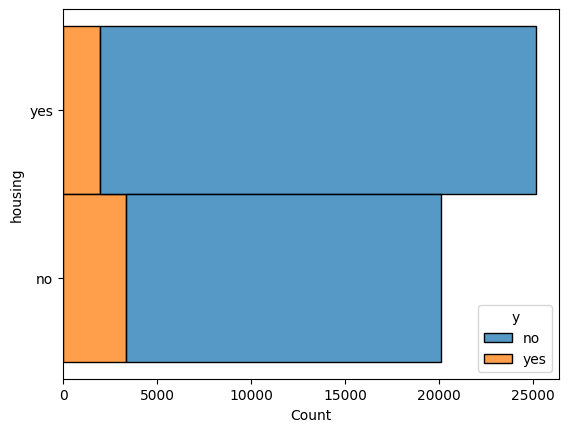

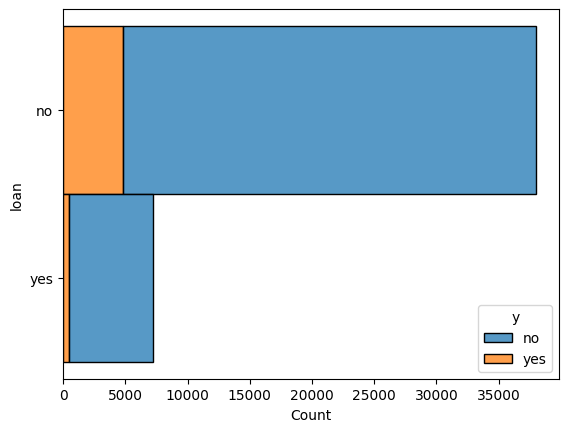

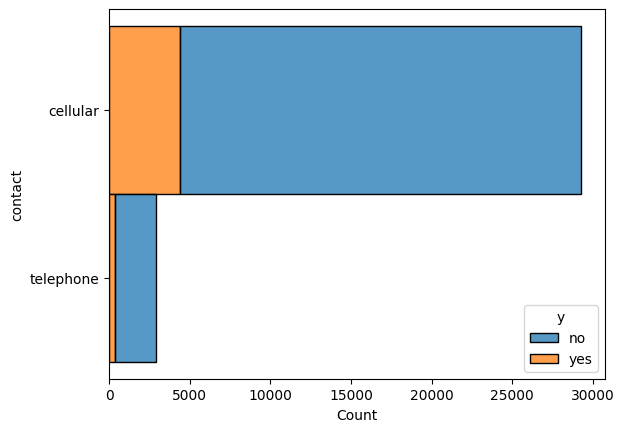

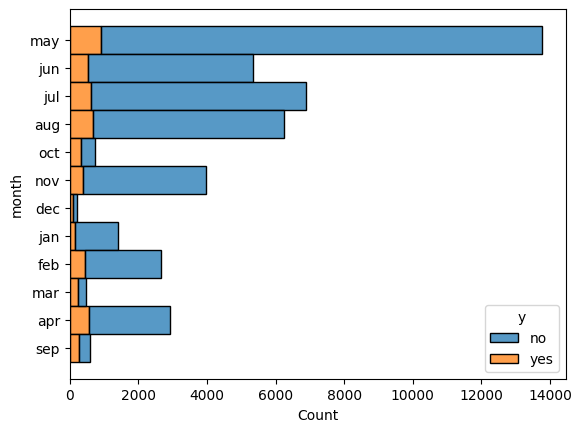

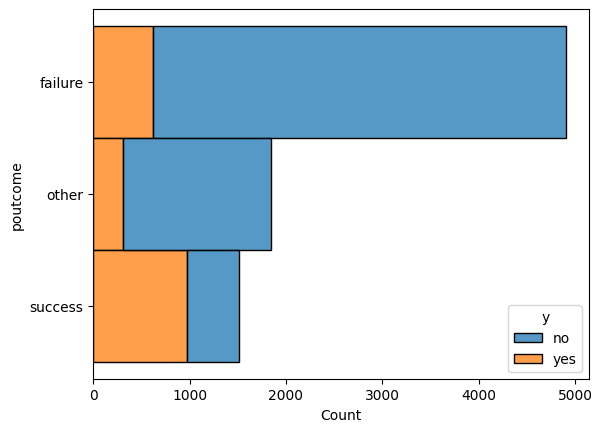

In [27]:
for col in cat_cols:
    sns.histplot(df, hue = 'y',y = col, multiple = 'stack')
    plt.show()

Thoughts on the distributions:
- y: very unbalanced outcome variable, much more no's than yes
- more successfull in higher income, higher education groups
- some seasonality
- previous yes good predictor for future yes

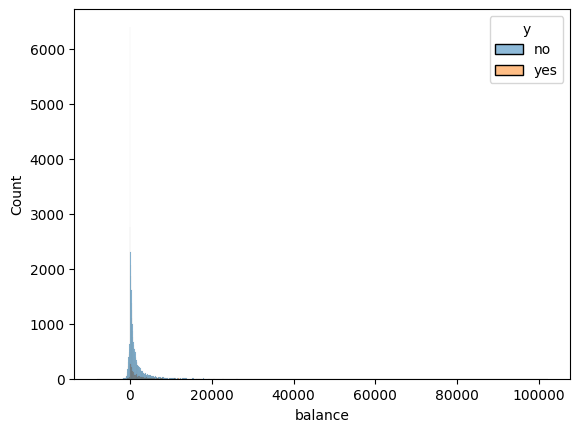

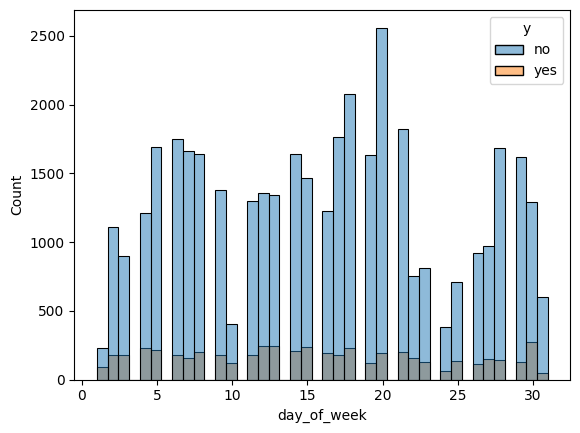

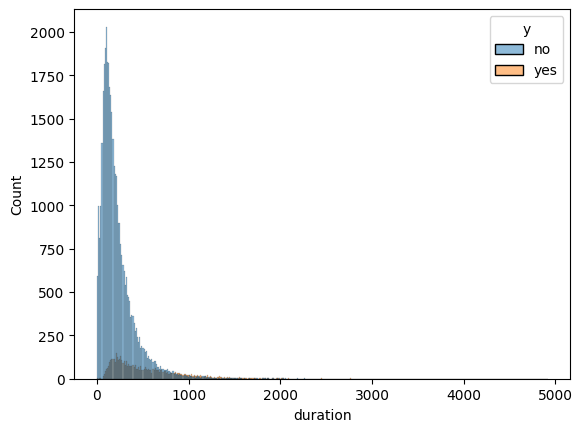

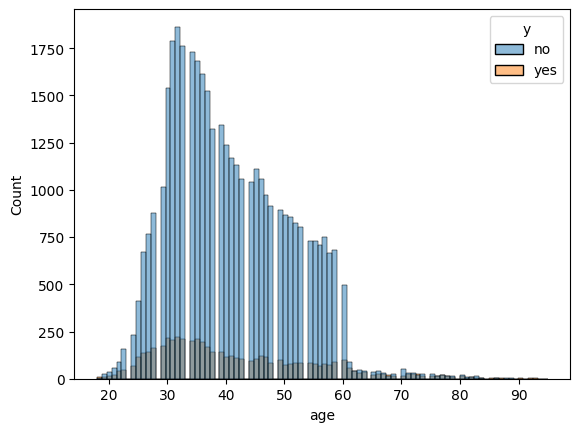

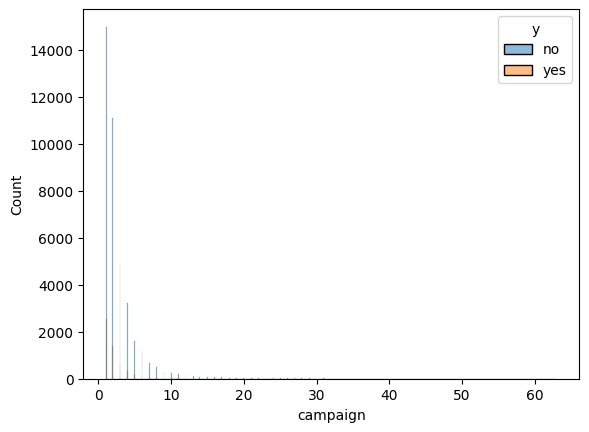

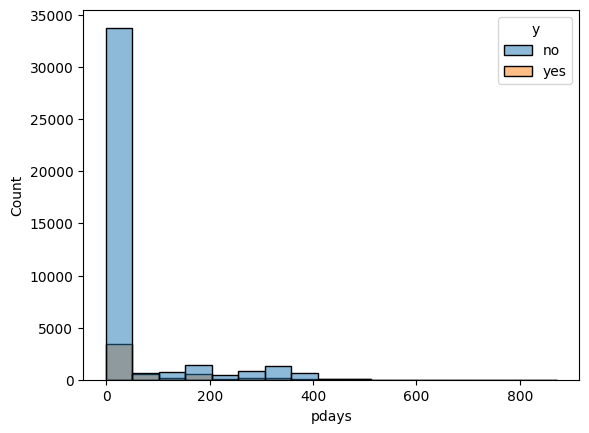

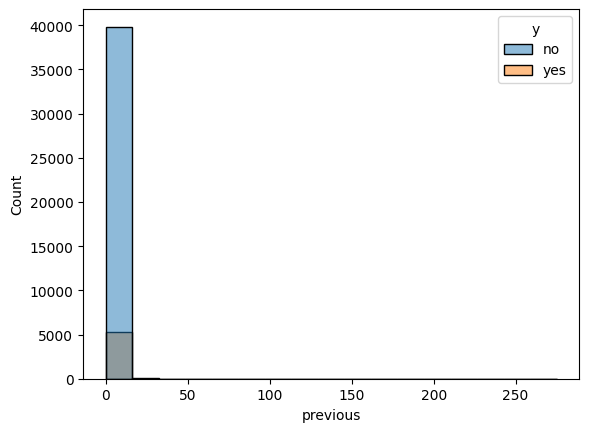

In [28]:
for col in num_cols:
    sns.histplot(df, hue = 'y',x = col)
    plt.show()


In [29]:
# Drop contact, poutcome due to excessive nas and duration since it shouldn't be used for prediction
df.drop(columns=['contact', 'duration', 'poutcome'], inplace=True) 


In [ ]:
# Look at summary stats of numerical variables
df.describe()


,age,balance,day_of_week,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,63.000000,871.000000,275.000000


Clearly outliers, especially for the balance.

In [ ]:
# Create age bins to remove some noise
age_bins = [0, 25, 40, 60, 100]
age_labels = ['<25', '25-40', '40-60', '60+']
df['age'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)

In [ ]:
# Transform outcome variable
df['y'] = df['y'].map({'yes': True, 'no': False})

# Separate features and target again after cleaning
y = df['y']
X = df.drop(columns='y')


# Model

In [ ]:
# Categorial columns without the dropped ones
cat_cols_cleaned =['job',
'age',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'month',
 ]

In [ ]:
## Create preprocessing and model pipeline

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),# Impute NA's
    ('encoder', OneHotEncoder(handle_unknown='ignore')) # One-hot encode cat variables
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_cols_cleaned)
    ], remainder='passthrough')
# Use RandomForest 
model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators = 100, random_state = 123))
])

In [35]:
## Modeling and prediction
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 123)

# Train Model
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.90      0.97      0.94      7985
        True       0.49      0.19      0.28      1058

    accuracy                           0.88      9043
   macro avg       0.70      0.58      0.61      9043
weighted avg       0.85      0.88      0.86      9043



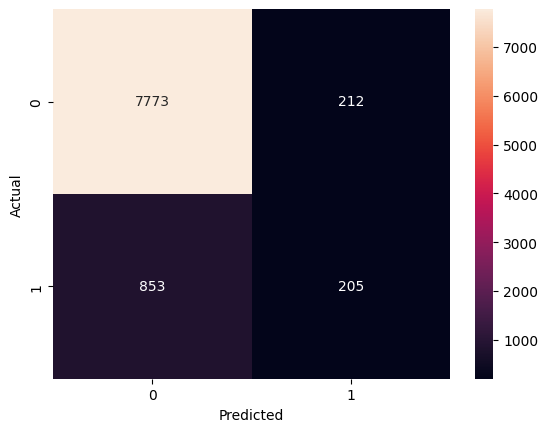

In [36]:
# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [37]:
# ROC AUC as evaluation metric due to imbalanced sample
y_proba = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
print(roc_auc)

0.7510799431353448


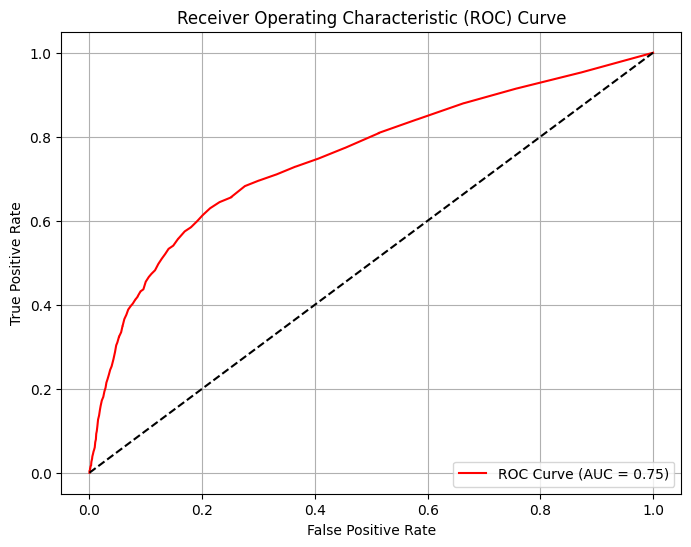

In [38]:
# Plot curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='red')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


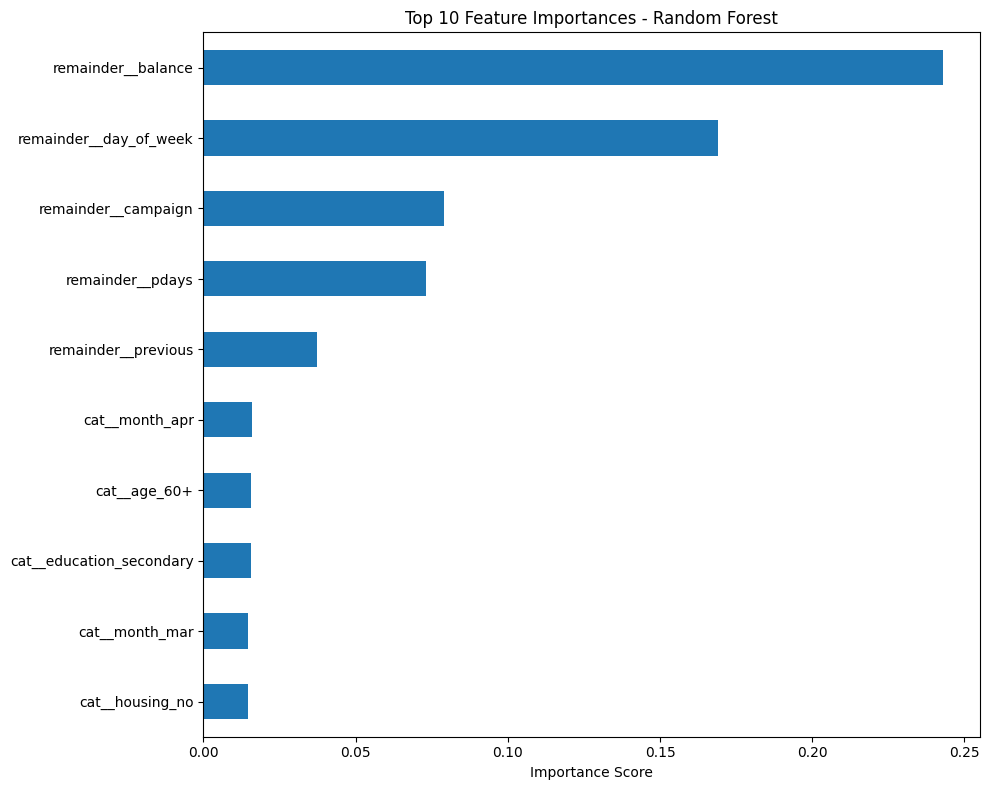

In [ ]:
# Look at most important features according to the model
classifier = model.named_steps['classifier']
preprocessed_features = model.named_steps['preprocessor'].get_feature_names_out()

feature_importances = pd.Series(classifier.feature_importances_, index=preprocessed_features)
feature_importances.nlargest(10).sort_values().plot(kind='barh', figsize=(10, 8))
plt.title('Top 10 Feature Importances - Random Forest')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# Weitere Fragen
* Würden Sie für die Voraussage noch weitere Datenpunkte in Erwägung ziehen? 
    * Ja, zB den aktuellen Zinssatz, wie lange die Person schon Kunde ist, Credit Score.
* Können die Erkenntnisse Ihrer Analyse auch für andere Bereiche der Bank verwendet werden? 
    * Ja, zB für Sales, hierbei wäre der Ansatz ähnlich.